In [1]:
#! python -m pip install lightkurve --upgrade;

In [2]:
#pip install lightkurve

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits           ## To read '.fits' files
from astropy.table import Table       ## Not using this for now
import scipy.optimize as sci
import pandas as pd
from IPython.display import display
from PIL import Image
import lightkurve as lk
import scipy as sc

In [4]:
## Defining standard astronomical constants to convert to and from relative quantities

l_sun = 3.85 * 10 ** 26
m_sun = 1.99 * 10 ** 30
r_sun = 6.957 * 10 ** 8

In [5]:
fits.getdata('table_2.fit', ext=1).columns

ColDefs(
    name = 'TIC'; format = 'I9'; start = 2
    name = 'Sec'; format = 'I1'; start = 12
    name = 'Nout'; format = 'I2'; start = 14
    name = 'Nfl'; format = 'I3'; start = 17
    name = 'Amp_mean'; format = 'F8.5'; start = 21
    name = 'FWHMdt_mean'; format = 'F8.5'; unit = 'd'; start = 30
    name = 'Ebol_mean'; format = 'E9.2'; unit = '10-7J'; start = 39
    name = 'MCME_mean'; format = 'E9.2'; unit = 'g'; start = 49
    name = 'Tmag'; format = 'F8.5'; unit = 'mag'; start = 59
    name = 'Teff'; format = 'I5'; unit = 'K'; start = 68
    name = 'Rad'; format = 'F9.6'; unit = 'Rsun'; start = 74
    name = 'logg'; format = 'F8.5'; unit = '[cm/s2]'; start = 84
    name = 'SpT'; format = 'A6'; start = 93
    name = 'Prot'; format = 'F9.6'; unit = 'd'; start = 100
    name = 'aFFD'; format = 'F6.3'; start = 110
    name = 'bFFD'; format = 'F7.3'; start = 117
    name = 'Chem'; format = 'I1'; start = 125
    name = 'O3cons'; format = 'I1'; start = 127
    name = 'O3perm'; format 

In [6]:
with fits.open('table_2.fit', mode="readonly") as table2:      ## Extracting info from select columns in Table 2
    teff = table2[1].data['Teff']                   
    r = table2[1].data['Rad']            
    ebol = table2[1].data['Ebol_mean']               
    amp = table2[1].data['Amp_mean'] 
    tic = table2[1].data['TIC']
    table_2 = table2[1].data
    prot = table2[1].data['Prot']
    tmag = table2[1].data['Tmag']
   

In [7]:
print((tmag))                ## Checking the first element of Table 2

[11.126  12.551  11.181  ...  9.116   8.4287 10.623 ]


In [8]:
def luminosity (temp, radius):                         # Luminosity in SI units (W)
    
    l = 5.670374 * (10)**(-8) * 4 * np.pi * (radius * r_sun)**2 * (temp)**4 
    return l

In [9]:
#luminosity(5772, 1)

In [10]:
def lum_to_mass (lum):                                ## Mass-Luminosity conversion (only for M < 0.7 M_sun)
    
    m = (lum / l_sun /.35)**(1/2.62) * m_sun
    return m

In [11]:
lum_to_mass (luminosity(5772, 1))

2.9643028859430064e+30

In [12]:
lum = []

for (i,j) in zip(teff, r):
    
    k = luminosity(i,j)
    lum.append(k)                ## Creating a list of the derived luminosities


In [13]:
print(len(lum))
print(len(r))
#print(lum)                  ## List of calulated luminosities

1228
1228


In [14]:
lum_array = np.array(lum)
index_to_remove = [np.where(lum_array == 0)][0]     ## Finding the index no. of all the elements that have zero luminosity

In [15]:
#print(index_to_remove[0])              ## List of index no. of all the elements that have incomplete values in Table 2
print(len(index_to_remove[0]))


170


In [16]:
## Filtering out the elements with incomplete data from select columns of Table 2

tic = np.delete(tic, index_to_remove[0])
lum = np.delete(lum, index_to_remove[0])
teff = np.delete(teff, index_to_remove[0])
r = np.delete(r, index_to_remove[0])
ebol = np.delete(ebol, index_to_remove[0])
amp = np.delete(amp, index_to_remove[0])
prot = np.delete(prot, index_to_remove[0])
tmag = np.delete(tmag, index_to_remove[0])

In [17]:
print(tic)                ## Checking if the values were filtered correctly

[  2761472   5656273   5676537 ... 441469231 444153368 453101762]


In [18]:
mass = []

for i in lum:
    
    j = lum_to_mass(i)
    mass.append(j)                    ## Creating list of masses using luminosity-mass relation
    
mass = [x / m_sun for x in mass]      ## Scaling all masses relative to M_sun 

In [19]:
#print(mass)

In [20]:
## Finding index numbers of all elements where mass of the star is greater than 0.6 M_sun

mass_array = np.array(mass)
index_to_remove = [np.where(mass_array > 0.6)][0]

In [21]:
#print(index_to_remove[0]) 

In [22]:
## Filtering out the elements with mass greater than 0.6 M_sun

tic = np.delete(tic, index_to_remove[0])
lum = np.delete(lum, index_to_remove[0])
teff = np.delete(teff, index_to_remove[0])
r = np.delete(r, index_to_remove[0])
ebol = np.delete(ebol, index_to_remove[0])
amp = np.delete(amp, index_to_remove[0])
prot = np.delete(prot, index_to_remove[0])
mass = np.delete(mass, index_to_remove[0])
tmag = np.delete(tmag, index_to_remove[0])

In [23]:
#print((prot))

In [24]:
## Finding all the index numbers where period of rotation is 0 (incomplete data)

prot_array = np.array(prot)
index_to_remove = [np.where(prot_array == 0)][0]

In [25]:
print(index_to_remove)

(array([  5,   9,  13,  21,  25,  30,  32,  34,  37,  38,  40,  43,  44,
        46,  47,  49,  52,  55,  63,  65,  70,  72,  78,  79,  81,  83,
        85,  87,  96,  98, 101, 102, 105, 107, 109, 111, 114, 115, 116,
       119, 130, 132, 133, 134, 136, 138, 140, 142, 144, 149, 151, 156,
       157, 158, 162, 164, 165, 167, 178, 183, 184, 185, 187, 189, 190,
       194, 196, 198, 201, 205, 210, 212, 214, 218, 220, 221, 224, 225,
       228, 229, 231, 234, 235, 238, 240, 241, 247, 251, 253, 256, 263,
       266, 267, 269, 280, 283, 284, 290, 294, 298, 301, 304, 309, 314,
       315, 320, 321, 322, 323, 328, 329, 337, 341, 346, 348, 350, 352,
       369, 371, 381, 382, 384, 393, 396, 405, 411, 418, 419, 426, 430,
       432, 438, 439, 442, 444, 449, 452, 458, 460, 468, 470, 472, 479,
       480, 486, 488, 489, 490, 493, 494, 495, 496, 500, 501, 502, 517,
       523, 525, 530, 531, 534, 536, 537, 545, 547, 548, 549, 550, 554,
       561, 563, 566, 573, 575, 578, 581, 582, 587, 588, 591, 5

In [26]:
## Filtering out the elements with period of rotation equal to 0

tic = np.delete(tic, index_to_remove[0])
lum = np.delete(lum, index_to_remove[0])
teff = np.delete(teff, index_to_remove[0])
r = np.delete(r, index_to_remove[0])
ebol = np.delete(ebol, index_to_remove[0])
amp = np.delete(amp, index_to_remove[0])
prot = np.delete(prot, index_to_remove[0])
mass = np.delete(mass, index_to_remove[0])
tmag = np.delete(tmag, index_to_remove[0])

In [27]:
#print((prot))

In [28]:
rossby_no = [x / 100 for x in prot]                 ## Rossby No. = Rotation Period / Turnover time ..... Here Turnover Time ~ 100 days for stars of similar mass

lum = [x / l_sun for x in lum]                      ## Scaling Luminosity w.r.t. L_sun so it's easier to analyze

In [29]:
#print(rossby_no)

In [30]:
## Creating a 'dictionary' for the new table with new number of elements and columns

dict = {'TESS Input Catalog identifier': tic, 'Tess magnitude': tmag, 'Luminosity (in L_sun)': lum, 'Effective Temp. (in K)': teff, 'Radius (in R_sun)': r, 'Period of Rotation (in days)': prot, 'Rossby Number': rossby_no, 'Bolometric Energy (in erg units)': ebol, 'Relative flare amplitude': amp, 'Mass (in M_sun)': mass}

In [31]:
table_2_new = pd.DataFrame(dict)                ## Making a new table with the info in the above box as columns

In [32]:
display(table_2_new)

,TESS Input Catalog identifier,Tess magnitude,Luminosity (in L_sun),Effective Temp. (in K),Radius (in R_sun),Period of Rotation (in days),Rossby Number,Bolometric Energy (in erg units),Relative flare amplitude,Mass (in M_sun)
0,2761472,12.55100,0.003575,3041,0.216026,0.958129,0.009581,1.470000e+33,0.75583,0.173843
1,5656273,9.21070,0.065435,3815,0.587235,0.431193,0.004312,1.060000e+33,0.01613,0.527276
2,5725904,13.82950,0.004682,3124,0.234268,0.330389,0.003304,1.190000e+33,0.66936,0.192703
3,5796048,10.80810,0.048189,3621,0.559388,0.555649,0.005556,7.540000e+33,0.13300,0.469167
4,7151484,9.87974,0.023122,3403,0.438721,1.152180,0.011522,4.130000e+32,0.03822,0.354490
...,...,...,...,...,...,...,...,...,...,...
450,431479577,13.55110,0.008920,3147,0.318630,0.596867,0.005969,6.860000e+32,0.15532,0.246443
451,434097152,12.45770,0.013264,3205,0.374616,4.907685,0.049077,5.670000e+32,0.06628,0.286741
452,434105094,13.63430,0.001992,2839,0.185013,4.970497,0.049705,2.060000e+32,0.34591,0.139062
453,441051650,10.82060,0.014210,3326,0.360044,3.500855,0.035009,4.580000e+32,0.05040,0.294379


### Calculating turnover times for all stars with mass < 0.6 M_sun

In [33]:
print(np.log10(10))
print(len(teff))

1.0
455


In [34]:
log_teff = [np.log10(x) for x in teff]
print(np.min(log_teff))
print(np.max(log_teff))
print(np.average(log_teff))

3.4473131088235682
3.6283889300503116
3.509704929969968


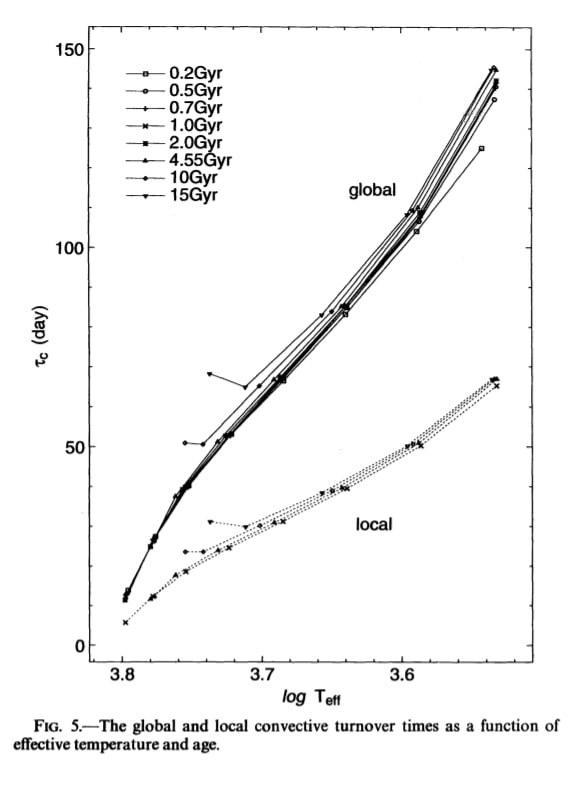

In [35]:
## Note: This is how you can add images to a Jupyter notebook

from IPython.display import Image                                 ## Import the package
turnovertime_teff = Image(filename='turnover_time-teff.jpg')      ## You will have to upload the image in 'jpg' format to the same folder as the notebook and use this command to import it
display(turnovertime_teff)                                        ## This just shows the image

Source for image: Kim, Y.-C., and Demarque, P. 1996, ApJ, 457, 340 

Since the average $log (T_{eff})$ is around 3.5, the above graph predicts the turnover time ($T_{c}$) to be between 100 and 150 days. Since the calculation of Rossby Number done using 100 days yielded all values less than 0.1, making the turnover time greater than 100 days wouldn't help in filtering out any more stars.

### Partially Convective / Not-Fully Convective Stars data:

In [36]:
## Finding index numbers of all stars with mass less than 0.4 M_sun

mass_array = np.array(mass)
index_to_remove = [np.where(mass_array < 0.4)][0]

In [37]:
## Creating lists of stars with mass between 0.4 M_sun and 0.6 M_sun

tic_non_conv = np.delete(tic, index_to_remove[0])
lum_non_conv = np.delete(lum, index_to_remove[0])
teff_non_conv = np.delete(teff, index_to_remove[0])
r_non_conv = np.delete(r, index_to_remove[0])
ebol_non_conv = np.delete(ebol, index_to_remove[0])
amp_non_conv = np.delete(amp, index_to_remove[0])
prot_non_conv = np.delete(prot, index_to_remove[0])
mass_non_conv = np.delete(mass, index_to_remove[0])
rossby_no_non_conv = np.delete(rossby_no, index_to_remove[0])
tmag_non_conv = np.delete(tmag, index_to_remove[0])

In [38]:
print(len(mass_non_conv))

82


In [39]:
## Calculating Relative Flare Energies from the formula in Scialog_2019 ..... E ~ B^2 L^3 / (8 pi)

flare_eng_non_conv = [x**2  for x in amp_non_conv]         ## Flare amplitudes (B) are relaive in Table 2 so units don't really matter here. L ~ 10^8 cm

In [40]:
## Creating a 'dictionary' for the new table with new number of elements and columns

dict_non_conv = {'TESS Input Catalog identifier': tic_non_conv, 'Tess magnitude': tmag_non_conv, 'Luminosity (in L_sun)': lum_non_conv, 'Effective Temp. (in K)': teff_non_conv, 'Radius (in R_sun)': r_non_conv, 'Period of Rotation (in days)': prot_non_conv, 'Rossby Number': rossby_no_non_conv, 'Bolometric Energy (in erg units)': ebol_non_conv, 'Relative flare amplitude': amp_non_conv, 'Mass (in M_sun)': mass_non_conv, 'Relative Flare Energies:': flare_eng_non_conv}

table_2_non_conv = pd.DataFrame(dict_non_conv)                ## Making a new table with the info in the above box as columns

display(table_2_non_conv)                                     ## Making a table for non-convective stars

,TESS Input Catalog identifier,Tess magnitude,Luminosity (in L_sun),Effective Temp. (in K),Radius (in R_sun),Period of Rotation (in days),Rossby Number,Bolometric Energy (in erg units),Relative flare amplitude,Mass (in M_sun),Relative Flare Energies:
0,5656273,9.2107,0.065435,3815,0.587235,0.431193,0.004312,1.060000e+33,0.01613,0.527276,0.000260
1,5796048,10.8081,0.048189,3621,0.559388,0.555649,0.005556,7.540000e+33,0.13300,0.469167,0.017689
2,12421477,11.7010,0.043505,3461,0.581786,0.358996,0.003590,4.080000e+33,0.05334,0.451209,0.002845
3,20892891,11.5143,0.032891,3516,0.490161,4.790643,0.047906,1.760000e+33,0.07501,0.405526,0.005627
4,25132999,10.8124,0.079914,3945,0.606897,4.920120,0.049201,1.050000e+34,0.10711,0.569080,0.011473
...,...,...,...,...,...,...,...,...,...,...,...
77,381977500,14.2431,0.043415,3312,0.634654,2.170426,0.021704,2.460000e+34,0.32554,0.450853,0.105976
78,394275759,12.0629,0.040006,3433,0.567039,0.933711,0.009337,2.080000e+33,0.04253,0.436999,0.001809
79,402319281,10.3052,0.070758,3723,0.641207,0.309838,0.003098,3.390000e+33,0.04404,0.543253,0.001940
80,403237836,10.5282,0.053369,3530,0.619429,0.426865,0.004269,2.660000e+33,0.04244,0.487811,0.001801


### Convective Stars data:

In [41]:
## Finding index numbers of all stars with mass greater than 0.4 M_sun

mass_array = np.array(mass)
index_to_remove = [np.where(mass_array >= 0.4)][0]

In [42]:
## Creating lists of stars with mass equal to or less than 0.4 M_sun

tic_conv = np.delete(tic, index_to_remove[0])
lum_conv = np.delete(lum, index_to_remove[0])
teff_conv = np.delete(teff, index_to_remove[0])
r_conv = np.delete(r, index_to_remove[0])
ebol_conv = np.delete(ebol, index_to_remove[0])
amp_conv = np.delete(amp, index_to_remove[0])
prot_conv = np.delete(prot, index_to_remove[0])
mass_conv = np.delete(mass, index_to_remove[0])
rossby_no_conv = np.delete(rossby_no, index_to_remove[0])
tmag_conv = np.delete(tmag, index_to_remove[0])

In [43]:
print(len(mass_conv))

373


In [44]:
## Calculating Relative Flare Energies from the formula in Scialog_2019 ..... E ~ B^2 L^3 / (8 pi)

flare_eng_conv = [x**2 for x in amp_conv]         ## Flare amplitudes (B) are relaive in Table 2 so units don't really matter here. L ~ 10^8 cm

In [45]:
## Creating a 'dictionary' for the new table with new number of elements and columns

dict_conv = {'TESS Input Catalog identifier': tic_conv, 'Tess magnitude': tmag_conv, 'Luminosity (in L_sun)': lum_conv, 'Effective Temp. (in K)': teff_conv, 'Radius (in R_sun)': r_conv, 'Period of Rotation (in days)': prot_conv, 'Rossby Number': rossby_no_conv, 'Bolometric Energy (in erg units)': ebol_conv, 'Relative flare amplitude': amp_conv, 'Mass (in M_sun)': mass_conv, 'Relative Flare Energies': flare_eng_conv}

table_2_conv = pd.DataFrame(dict_conv)                ## Making a new table with the info in the above box as columns

display(table_2_conv)                                 ## Making a table for convective stars

,TESS Input Catalog identifier,Tess magnitude,Luminosity (in L_sun),Effective Temp. (in K),Radius (in R_sun),Period of Rotation (in days),Rossby Number,Bolometric Energy (in erg units),Relative flare amplitude,Mass (in M_sun),Relative Flare Energies
0,2761472,12.55100,0.003575,3041,0.216026,0.958129,0.009581,1.470000e+33,0.75583,0.173843,0.571279
1,5725904,13.82950,0.004682,3124,0.234268,0.330389,0.003304,1.190000e+33,0.66936,0.192703,0.448043
2,7151484,9.87974,0.023122,3403,0.438721,1.152180,0.011522,4.130000e+32,0.03822,0.354490,0.001461
3,12423835,12.99490,0.010283,3190,0.332948,2.844444,0.028444,3.130000e+33,0.28766,0.260188,0.082748
4,12471629,11.71260,0.018809,3213,0.443879,2.229400,0.022294,4.640000e+32,0.03139,0.327631,0.000985
...,...,...,...,...,...,...,...,...,...,...,...
368,431479577,13.55110,0.008920,3147,0.318630,0.596867,0.005969,6.860000e+32,0.15532,0.246443,0.024124
369,434097152,12.45770,0.013264,3205,0.374616,4.907685,0.049077,5.670000e+32,0.06628,0.286741,0.004393
370,434105094,13.63430,0.001992,2839,0.185013,4.970497,0.049705,2.060000e+32,0.34591,0.139062,0.119654
371,441051650,10.82060,0.014210,3326,0.360044,3.500855,0.035009,4.580000e+32,0.05040,0.294379,0.002540


### KS Test p-values 

KstestResult(statistic=0.5862486104753809, pvalue=1.9634191726805532e-22)


Text(0, 0.5, 'Relative Flare Energies')

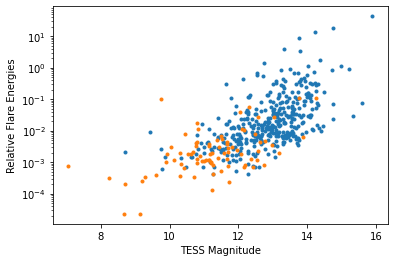

In [46]:
#conv_list = flare_eng_conv.sort()
#non_conv_list = flare_eng_non_conv.sort()

print(sc.stats.ks_2samp(flare_eng_conv, flare_eng_non_conv))

plt.plot( tmag_conv, flare_eng_conv, '.')          ## Blue
plt.plot( tmag_non_conv,flare_eng_non_conv, '.')   ## Orange
plt.yscale('log')
#plt.xlim(11,13.1)
plt.xlabel('TESS Magnitude')
plt.ylabel('Relative Flare Energies')

In [47]:
tess_conv_array = np.array(tmag_conv)
index_to_remove = [np.where((tess_conv_array <= 11) | (tess_conv_array >= 13))][0]

new_tmag_conv = np.delete(tmag_conv, index_to_remove[0])
new_flare_eng_conv = np.delete(flare_eng_conv, index_to_remove[0])

In [48]:
print(len(new_tmag_conv))
print(len(tmag_conv))

170
373


In [49]:
tess_non_conv_array = np.array(tmag_non_conv)
index_to_remove = [np.where((tess_non_conv_array <= 11) | (tess_non_conv_array >= 13))][0]

new_tmag_non_conv = np.delete(tmag_non_conv, index_to_remove[0])
new_flare_eng_non_conv = np.delete(flare_eng_non_conv, index_to_remove[0])

In [50]:
print((new_tmag_non_conv))
print(len(tmag_non_conv))

[11.701  11.5143 11.6985 12.9768 12.5781 11.4002 11.6704 11.9629 12.1152
 12.525  11.1395 11.1395 12.4736 11.1364 11.7342 12.1827 12.5616 12.1607
 11.2686 11.2111 12.2972 11.6603 12.7568 12.6205 11.2456 11.2551 11.0673
 12.7553 11.4982 11.154  12.4103 11.422  11.3804 11.6977 11.1681 11.4831
 11.1946 12.1585 11.6752 12.0403 11.8214 11.5931 12.3629 11.231  12.0629]
82


Text(0, 0.5, 'Relative Flare Energies')

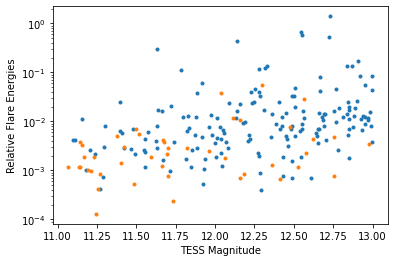

In [51]:
plt.plot( new_tmag_conv, new_flare_eng_conv, '.')            ## Blue
plt.plot( new_tmag_non_conv, new_flare_eng_non_conv, '.')    ## Orange
plt.yscale('log')
plt.xlabel('TESS Magnitude')
plt.ylabel('Relative Flare Energies')

Text(0, 0.5, 'CDF')

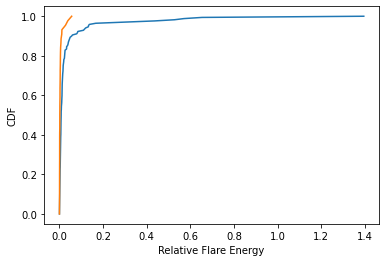

In [52]:
## using basic principles to plot cdf

sorted_conv = np.sort(new_flare_eng_conv)
sorted_non_conv = np.sort(new_flare_eng_non_conv)

cdf_conv = np.arange(len(new_flare_eng_conv)) / (len(new_flare_eng_conv) - 1)
cdf_non_conv = np.arange(len(new_flare_eng_non_conv)) / (len(new_flare_eng_non_conv) - 1)

plt.plot(sorted_conv, cdf_conv)                ## Blue
plt.plot(sorted_non_conv, cdf_non_conv)        ## Orange
plt.xlabel('Relative Flare Energy')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

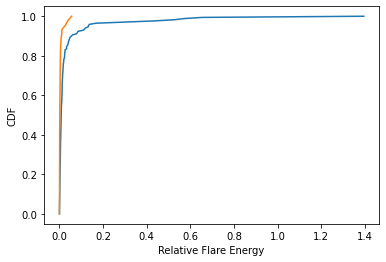

In [53]:
## using pre-made functions to find cdf

def cdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_cdf(a):
    x, y = cdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y)
    
plot_cdf(new_flare_eng_conv)          ## Blue
plot_cdf(new_flare_eng_non_conv)      ## Orange
plt.xlabel('Relative Flare Energy')
plt.ylabel('CDF')
#plt.xlim(0,0.1)

In [54]:
## 2 value KS TEST

print(sc.stats.ks_2samp(new_flare_eng_conv, new_flare_eng_non_conv)[0])

0.4823529411764706


### Using Lightkurve to get lightcurves of stars (to find spot filling factor)

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


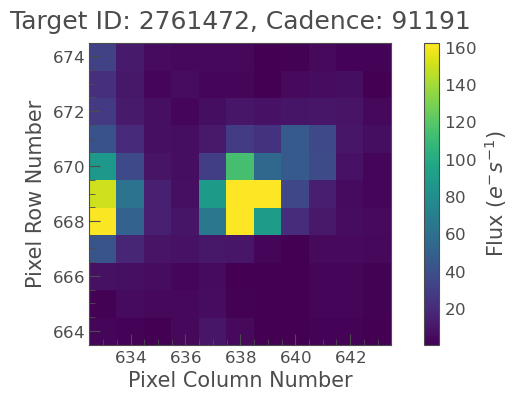

In [55]:
from lightkurve import search_targetpixelfile
pixelfile = search_targetpixelfile("TIC 2761472",).download();
pixelfile.plot(frame=1);

[1354.11354767 1354.11493661 1354.11632555 ... 1381.51666648 1381.51805536
 1381.51944424]
[2636.739  2652.173  2662.6116 ... 2693.0515 2633.0037 2605.127 ] electron / s


(2350.0, 2800.0)

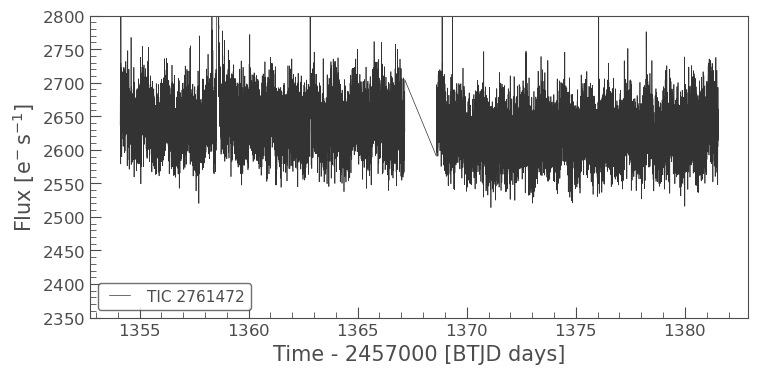

In [56]:
lc = pixelfile.to_lightcurve(aperture_mask='all');
print(lc.time)
print(lc.flux)
lc.plot();

plt.ylim(2350,2800)

In [57]:
print(np.average(lc.flux))
print(np.median(lc.flux))

2640.527099609375 electron / s
2634.5029296875 electron / s


### Looping to get ${\delta}f$ for each star in fully convective list

In [58]:
delta_f_conv = []
avg_flux_conv = []
std_conv = []
median_conv = []
tic_conv = [str(x) for x in tic_conv]

for i in tic_conv:

    TIC = i # Input TIC

    # Search for the lightkurve

    search_result = lk.search_lightcurve('TIC ' + TIC, mission='TESS',author='SPOC')

    # Download all available TESS lightcurves (i.e. from different sectors)
    lc = search_result.download()

    # Combine the different lightkurves

    #lc = lc_collection.stitch()

    # Normalize the lightcurve

    lc = lc.normalize()

    # Get out a flux and time array

    timeArray = lc['time'].value # these are numpy arrays
    fluxArray = lc['sap_flux'].value
    fluxArray = fluxArray[np.logical_not(np.isnan(fluxArray))]
    
    
    # Filter out the last 450 data points to avoid running into flares and other irregularities

    #timeArray = timeArray[-500:-50:]
    #fluxArray = fluxArray[-500:-50:]
    
    std = np.std(fluxArray)
    mean = np.average(fluxArray)
    median = np.median(fluxArray)
    
    flux = np.array(fluxArray)
    index_to_remove = [np.where((flux >= mean + 3 * std) & (flux <= mean - 3* std))][0]     ## Removing all points that lie outside of 3 sigma
    
    timeArray = np.delete(timeArray, index_to_remove[0])
    fluxArray = np.delete(fluxArray, index_to_remove[0])

    # Get the average, min and max values

    fluxMin = np.min(fluxArray)
    fluxMax = np.max(fluxArray)
    fluxWidth = fluxMax - fluxMin
    fluxAvg = np.average(fluxArray)
    
    # Append to the list that has data for all stars
    
    delta_f_conv.append(fluxWidth)
    avg_flux_conv.append(fluxAvg)
    std_conv.append(std)
    median_conv.append(median)

print(fluxWidth)
print(fluxAvg)

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/idies/miniconda3/envs/py38/lib/

122.70117
924.83246


In [59]:
#print((delta_f_conv))
#print(std_conv)

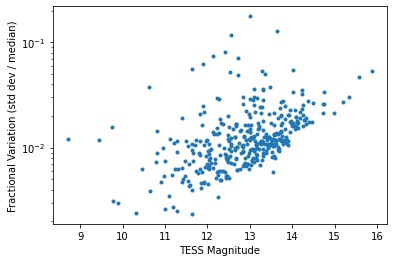

In [60]:
ratio_conv = [x / y for x,y in zip(std_conv, median_conv)]       ## Standard deviation / median ratio
plt.plot(tmag_conv, ratio_conv, '.')
plt.xlabel('TESS Magnitude')
plt.ylabel('Fractional Variation (std dev / median)')
plt.yscale("log")

### Looping to get ${\delta}f$ for each star in partially convective list

In [61]:
delta_f_non_conv = []
avg_flux_non_conv = []
std_non_conv = []
median_non_conv = []
tic_non_conv = [str(x) for x in tic_non_conv]

for i in tic_non_conv:

    TIC = i # Input TIC

    # Search for the lightkurve

    search_result = lk.search_lightcurve('TIC ' + TIC, mission='TESS',author='SPOC')

    # Download all available TESS lightcurves (i.e. from different sectors)
    lc = search_result.download()

    # Combine the different lightkurves

    #lc = lc_collection.stitch()

    # Normalize the lightcurve

    lc = lc.normalize()

    # Get out a flux and time array

    timeArray = lc['time'].value # these are numpy arrays
    fluxArray = lc['sap_flux'].value
    fluxArray = fluxArray[np.logical_not(np.isnan(fluxArray))]
    
    # Filter out the last 450 data points to avoid running into flares and other irregularities

    #timeArray = timeArray[-250:-50:]
    #fluxArray = fluxArray[-250:-50:]
    
    std = np.std(fluxArray)
    mean = np.average(fluxArray)
    median = np.median(fluxArray)
    
    flux = np.array(fluxArray)
    index_to_remove = [np.where((flux >= mean + 3 * std) & (flux <= mean - 3* std))][0]        ## Removing all points that lie outside of 3 sigma
    
    timeArray = np.delete(timeArray, index_to_remove[0])
    fluxArray = np.delete(fluxArray, index_to_remove[0])
   

    # Get the average, min and max values

    fluxMin = np.min(fluxArray)
    fluxMax = np.max(fluxArray)
    fluxWidth = fluxMax - fluxMin
    fluxAvg = np.average(fluxArray)
    
    # Append to the list that has data for all stars
    
    delta_f_non_conv.append(fluxWidth)
    avg_flux_non_conv.append(fluxAvg)
    std_non_conv.append(std)
    median_non_conv.append(median)

print(fluxWidth)
print(fluxAvg)

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/idies/miniconda3/envs/py38/lib/

761.85547
9689.766


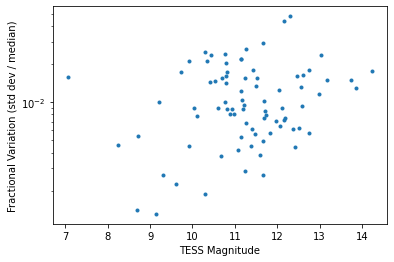

In [62]:
ratio_non_conv = [x / y for x,y in zip(std_non_conv, median_non_conv)]    ## Standard deviation / median ratio
plt.plot(tmag_non_conv, ratio_non_conv, '.')
plt.xlabel('TESS Magnitude')
plt.ylabel('Fractional Variation (std dev / median)')
plt.yscale("log")

In [63]:
print(np.max(delta_f_non_conv))

20404.266


In [64]:
delta_f_non_conv.index(np.max(delta_f_non_conv))

56

In [65]:
delta_f_non_conv[56]

20404.266

In [66]:
tic_non_conv[56]

'262039241'

### Both fractional variance plots together

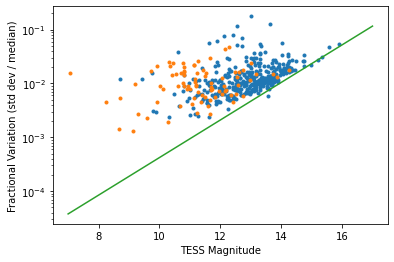

In [67]:
x = np.linspace(7, 17, 100)
y = 1.3743 * 10 ** (-7) * 2.23149 ** (x)

plt.plot(tmag_conv, ratio_conv, '.')                       ## Blue
plt.plot(tmag_non_conv, ratio_non_conv, '.')               ## Orange
plt.plot(x,y)
plt.xlabel('TESS Magnitude')
plt.ylabel('Fractional Variation (std dev / median)')
plt.yscale("log")

In [68]:
delta_conv = []
delta_non_conv = []

def frac_var (tmag, ratio):
    
    y = 1.3743 * 10 ** (-7) * np.power(2.23149, tmag)
    delta = np.power(np.abs(np.power(y, 2) - np.power(ratio, 2)), .5)            ## Delta = sqrt (|curve ^2 - datapoint ^ 2|)
    return delta

for (i,j) in zip(tmag_conv, ratio_conv):
    k = frac_var(tmag_conv, ratio_conv)
    delta_conv.append(k)
    
for (i,j) in zip(tmag_non_conv, ratio_non_conv):
    k = frac_var(tmag_non_conv, ratio_non_conv)
    delta_non_conv.append(k)

delta_conv = delta_conv[1]
delta_non_conv = delta_non_conv[1]
print(len(delta_conv))
print(len(delta_non_conv))

373
82


KstestResult(statistic=0.1047538089321912, pvalue=0.4187969521656486)


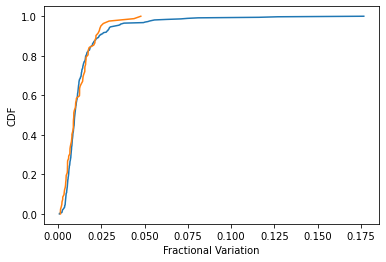

In [69]:
plot_cdf(delta_conv)          ## Blue
plot_cdf(delta_non_conv)      ## Orange
plt.xlabel('Fractional Variation')
plt.ylabel('CDF')

## 2 value KS TEST
#print(delta_conv)
print(sc.stats.ks_2samp(delta_conv, delta_non_conv))

In [70]:
## Spot Filling Factor

spotff_conv = [x / y * 100 for x,y in zip(delta_conv, median_conv)]
print(len(spotff_conv))
spotff_non_conv = [x / y * 100 for x,y in zip(delta_non_conv, median_non_conv)]
print(len(spotff_non_conv))

373
82


KstestResult(statistic=0.5367815340351795, pvalue=1.4057414097785708e-18)


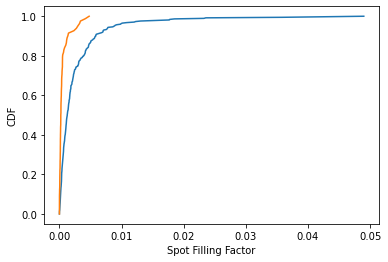

In [71]:
plot_cdf(spotff_conv)          ## Blue
plot_cdf(spotff_non_conv)      ## Orange
plt.xlabel('Spot Filling Factor')
plt.ylabel('CDF')

## 2 value KS TEST for spot filling factor

print(sc.stats.ks_2samp(spotff_conv, spotff_non_conv))

### Sliding the mass that separates Fully Convective and Partially Convective stars

In [97]:
ks_stat = []
ks_p = []

ks_FracVar_stat = []
ks_FracVar_p = []

mass_slider = np.linspace(0.2, 0.5, 41)

for i in mass_slider:
    
    mass_array = np.array(mass)
    
    index_to_remove = [np.where(mass_array >= i)][0]              ## Fully convective stars
    new_tic_conv = np.delete(tic, index_to_remove[0])
    new_lum_conv = np.delete(lum, index_to_remove[0])
    new_teff_conv = np.delete(teff, index_to_remove[0])
    new_r_conv = np.delete(r, index_to_remove[0])
    new_ebol_conv = np.delete(ebol, index_to_remove[0])
    new_amp_conv = np.delete(amp, index_to_remove[0])
    new_prot_conv = np.delete(prot, index_to_remove[0])
    new_mass_conv = np.delete(mass, index_to_remove[0])
    new_rossby_no_conv = np.delete(rossby_no, index_to_remove[0])
    new_tmag_conv = np.delete(tmag, index_to_remove[0])
    
    index_to_remove = [np.where(mass_array < i)][0]               ## Partially Convective
    new_tic_non_conv = np.delete(tic, index_to_remove[0])
    new_lum_non_conv = np.delete(lum, index_to_remove[0])
    new_teff_non_conv = np.delete(teff, index_to_remove[0])
    new_r_non_conv = np.delete(r, index_to_remove[0])
    new_ebol_non_conv = np.delete(ebol, index_to_remove[0])
    new_amp_non_conv = np.delete(amp, index_to_remove[0])
    new_prot_non_conv = np.delete(prot, index_to_remove[0])
    new_mass_non_conv = np.delete(mass, index_to_remove[0])
    new_rossby_no_non_conv = np.delete(rossby_no, index_to_remove[0])
    new_tmag_non_conv = np.delete(tmag, index_to_remove[0])
    
    new_flare_eng_conv = [x**2 for x in new_amp_conv]
    new_flare_eng_non_conv = [x**2 for x in new_amp_non_conv]
    
    new_tess_conv_array = np.array(new_tmag_conv)
    index_to_remove = [np.where((new_tess_conv_array <= 11) | (new_tess_conv_array >= 13.2))][0]

    new_tmag_conv = np.delete(new_tmag_conv, index_to_remove[0])
    new_flare_eng_conv = np.delete(new_flare_eng_conv, index_to_remove[0])
    
    new_tess_non_conv_array = np.array(new_tmag_non_conv)
    index_to_remove = [np.where((new_tess_non_conv_array <= 11) | (new_tess_non_conv_array >= 13.2))][0]

    new_tmag_non_conv = np.delete(new_tmag_non_conv, index_to_remove[0])
    new_flare_eng_non_conv = np.delete(new_flare_eng_non_conv, index_to_remove[0])
    
    ksStat = sc.stats.ks_2samp(new_flare_eng_conv, new_flare_eng_non_conv)[0]
    ksP = sc.stats.ks_2samp(new_flare_eng_conv, new_flare_eng_non_conv)[1]
    
    ks_stat.append(ksStat)
    ks_p.append(ksP)
    
    
print(len(ks_p))
print(len(ks_stat))


41
41


In [98]:
print(ks_p)
print('')
print(ks_stat)

[0.10171529322728323, 0.059333033863817275, 0.22439441902560497, 0.3302087773474627, 0.15816961539297603, 0.04935699036166685, 0.026844040299662808, 0.006208010107692452, 0.015933350607425067, 0.00047292049574376716, 0.00015406852281374395, 8.108256553684967e-05, 1.0619297935332561e-05, 1.3286762114317341e-05, 5.878908370227087e-06, 2.9189735981649534e-06, 1.9807383274672574e-06, 9.594936556389655e-08, 1.3025560762214283e-06, 9.097904429822279e-09, 9.801430334022143e-09, 7.42254147034771e-10, 3.493327849213301e-11, 1.606292876488169e-11, 6.139996289178384e-10, 8.103795412495174e-11, 1.7428439802458229e-09, 4.1093084490739784e-10, 1.5890828652942446e-09, 6.736706081866828e-09, 2.883264549335962e-08, 7.396660772762687e-08, 1.3256493136548642e-07, 1.3256493136548642e-07, 1.3406836906204589e-06, 5.290399981383587e-05, 1.5784721858480566e-06, 1.5784721858480566e-06, 5.161459128544266e-06, 0.00017699293841977326, 0.00017699293841977326]

[0.23325670498084292, 0.24380630630630631, 0.171383647

Text(0, 0.5, 'KS statistic ')

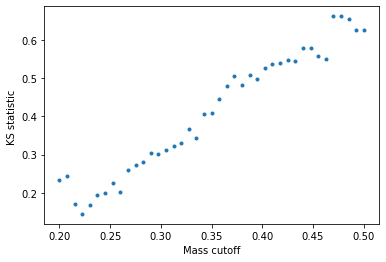

In [99]:
plt.plot(mass_slider, ks_stat, '.')
plt.xlabel('Mass cutoff')
plt.ylabel('KS statistic ')

Text(0, 0.5, 'KS p-value ')

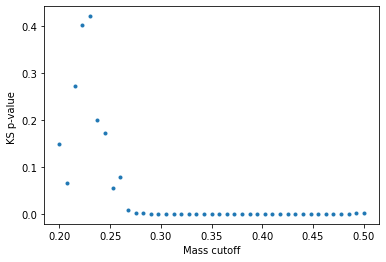

In [90]:
plt.plot(mass_slider, ks_p, '.')
plt.xlabel('Mass cutoff')
plt.ylabel('KS p-value ')

### Assuming M = 0.23 Msun as the cutoff

In [100]:
mass_array = np.array(mass)
    
index_to_remove = [np.where(mass_array >= 0.23)][0]              ## Fully convective stars
new_tic_conv = np.delete(tic, index_to_remove[0])
new_lum_conv = np.delete(lum, index_to_remove[0])
new_teff_conv = np.delete(teff, index_to_remove[0])
new_r_conv = np.delete(r, index_to_remove[0])
new_ebol_conv = np.delete(ebol, index_to_remove[0])
new_amp_conv = np.delete(amp, index_to_remove[0])
new_prot_conv = np.delete(prot, index_to_remove[0])
new_mass_conv = np.delete(mass, index_to_remove[0])
new_rossby_no_conv = np.delete(rossby_no, index_to_remove[0])
new_tmag_conv = np.delete(tmag, index_to_remove[0])
    
index_to_remove = [np.where(mass_array < 0.23)][0]               ## Partially Convective
new_tic_non_conv = np.delete(tic, index_to_remove[0])
new_lum_non_conv = np.delete(lum, index_to_remove[0])
new_teff_non_conv = np.delete(teff, index_to_remove[0])
new_r_non_conv = np.delete(r, index_to_remove[0])
new_ebol_non_conv = np.delete(ebol, index_to_remove[0])
new_amp_non_conv = np.delete(amp, index_to_remove[0])
new_prot_non_conv = np.delete(prot, index_to_remove[0])
new_mass_non_conv = np.delete(mass, index_to_remove[0])
new_rossby_no_non_conv = np.delete(rossby_no, index_to_remove[0])
new_tmag_non_conv = np.delete(tmag, index_to_remove[0])
    
new_flare_eng_conv = [x**2 for x in new_amp_conv]
new_flare_eng_non_conv = [x**2 for x in new_amp_non_conv]

new_tess_conv_array = np.array(new_tmag_conv)
index_to_remove = [np.where((new_tess_conv_array <= 11) | (new_tess_conv_array >= 13))][0]

new_tmag_conv = np.delete(new_tmag_conv, index_to_remove[0])
new_flare_eng_conv = np.delete(new_flare_eng_conv, index_to_remove[0])
    
new_tess_non_conv_array = np.array(new_tmag_non_conv)
index_to_remove = [np.where((new_tess_non_conv_array <= 11) | (new_tess_non_conv_array >= 13))][0]

new_tmag_non_conv = np.delete(new_tmag_non_conv, index_to_remove[0])
new_flare_eng_non_conv = np.delete(new_flare_eng_non_conv, index_to_remove[0])

Text(0, 0.5, 'CDF')

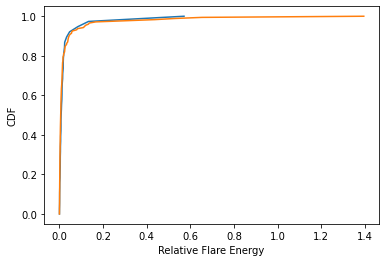

In [101]:
## using basic principles to plot cdf

sorted_conv = np.sort(new_flare_eng_conv)
sorted_non_conv = np.sort(new_flare_eng_non_conv)

cdf_conv = np.arange(len(new_flare_eng_conv)) / (len(new_flare_eng_conv) - 1)
cdf_non_conv = np.arange(len(new_flare_eng_non_conv)) / (len(new_flare_eng_non_conv) - 1)

plt.plot(sorted_conv, cdf_conv)                ## Blue
plt.plot(sorted_non_conv, cdf_non_conv)        ## Orange
plt.xlabel('Relative Flare Energy')
plt.ylabel('CDF')

## TESTING THINGS

In [76]:
lc.keys()

['time',
 'flux',
 'flux_err',
 'timecorr',
 'cadenceno',
 'centroid_col',
 'centroid_row',
 'sap_flux',
 'sap_flux_err',
 'sap_bkg',
 'sap_bkg_err',
 'pdcsap_flux',
 'pdcsap_flux_err',
 'quality',
 'psf_centr1',
 'psf_centr1_err',
 'psf_centr2',
 'psf_centr2_err',
 'mom_centr1',
 'mom_centr1_err',
 'mom_centr2',
 'mom_centr2_err',
 'pos_corr1',
 'pos_corr2']

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 28 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


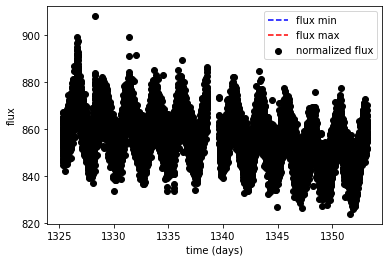

In [77]:
TIC = tic_non_conv[6] # Input TIC

# Search for the lightkurve

search_result = lk.search_lightcurve('TIC ' + TIC, mission='TESS',author='SPOC')

# Download all available TESS lightcurves (i.e. from different sectors)
lc = search_result.download()

# Combine the different lightkurves

#lc = lc_collection.stitch()

# Normalize the lightcurve

lc = lc.normalize()

# Get out a flux and time array

timeArray = lc['time'].value # these are numpy arrays
fluxArray = lc['sap_flux'].value


#timeArray = timeArray[-5000:-50:]
#fluxArray = fluxArray[-5000:-50:]
# Get the min and max values

fluxMin = np.min(fluxArray)
fluxMax = np.max(fluxArray)
fluxWidth = fluxMax - fluxMin

# Plot

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(timeArray,fluxArray,color='black',label="normalized flux")
ax.plot([np.min(timeArray),np.max(timeArray)],[fluxMin,fluxMin],color='blue',linestyle='--',label='flux min')
ax.plot([np.min(timeArray),np.max(timeArray)],[fluxMax,fluxMax],color='red',linestyle='--',label='flux max')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.legend()
plt.show(block=False)

In [78]:
print(fluxWidth)

nan


/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


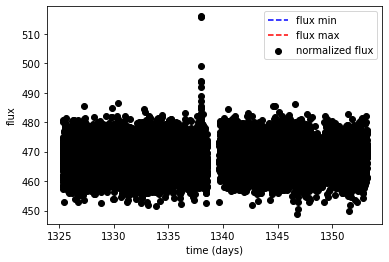

In [79]:
TIC = '431479577' # Input TIC

# Search for the lightkurve

search_result = lk.search_lightcurve('TIC ' + TIC, mission='TESS',author='SPOC')

# Download all available TESS lightcurves (i.e. from different sectors)
lc = search_result.download()

# Combine the different lightkurves

#lc = lc_collection.stitch()

# Normalize the lightcurve

lc = lc.normalize()

# Get out a flux and time array

timeArray = lc['time'].value # these are numpy arrays
fluxArray = lc['sap_flux'].value


#timeArray = timeArray[-5000:-50:]
#fluxArray = fluxArray[-5000:-50:]
# Get the min and max values

fluxMin = np.min(fluxArray)
fluxMax = np.max(fluxArray)
fluxWidth = fluxMax - fluxMin

# Plot

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(timeArray,fluxArray,color='black',label="normalized flux")
ax.plot([np.min(timeArray),np.max(timeArray)],[fluxMin,fluxMin],color='blue',linestyle='--',label='flux min')
ax.plot([np.min(timeArray),np.max(timeArray)],[fluxMax,fluxMax],color='red',linestyle='--',label='flux max')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.legend()
plt.show(block=False)